#### MTA Data Exploratory Data Analysis

This notebook performs comprehensive EDA on the MTA preprocessed data.


#### 1. Setup and Data Loading


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import string
from collections import Counter
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)


In [2]:
# Load the preprocessed data
data_path = 'Preprocessed/MTA_Data_preprocessed.csv'
df = pd.read_csv(data_path)

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()


Dataset shape: (230012, 6)

Columns: ['Alert ID', 'Date', 'Agency', 'Status Label', 'Affected', 'Header']

First few rows:


,Alert ID,Date,Agency,Status Label,Affected,Header
0,180128,11/05/2022 05:58:00 PM,NYCT Subway,delays,"[""A"", ""C""]",A C trains are delayed while we conduct emerge...
1,189489,12/20/2022 07:09:00 PM,NYCT Subway,delays,"[""L""]",L trains are running with delays in both direc...
2,189321,12/20/2022 12:31:00 AM,NYCT Subway,delays,"[""J""]",Jamaica-bound J trains are delayed while we re...
3,188948,12/18/2022 06:12:00 AM,NYCT Subway,delays,"[""Q""]",Southbound Q trains are running with delays af...
4,187749,12/12/2022 02:26:00 PM,NYCT Subway,delays,"[""B"", ""C""]",Southbound B C trains are running with delays ...


In [3]:
# Create EDA output directory
output_dir = 'EDA'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Created directory: {output_dir}")
else:
    print(f"Directory already exists: {output_dir}")


Directory already exists: EDA


#### 2. Missing Values Analysis


In [4]:
# Calculate missing values
missing_values = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum().values,
    'Missing_Percentage': (df.isnull().sum().values / len(df) * 100).round(2)
})

# Save to CSV
missing_values.to_csv(f'{output_dir}/missing_values.csv', index=False)
print("Missing Values Analysis:")
print(missing_values)
print(f"\nSaved to {output_dir}/missing_values.csv")


Missing Values Analysis:
         Column  Missing_Count  Missing_Percentage
0      Alert ID              0                 0.0
1          Date              0                 0.0
2        Agency              0                 0.0
3  Status Label              0                 0.0
4      Affected              0                 0.0
5        Header              0                 0.0

Saved to EDA/missing_values.csv


#### 3. Text Length and Token Analysis


In [5]:
# Tokenize headers and calculate statistics
df['token_count'] = df['Header'].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)
df['char_length'] = df['Header'].apply(lambda x: len(str(x)) if pd.notna(x) else 0)

# Calculate token statistics
token_stats = pd.DataFrame({
    'Metric': ['Mean Tokens', 'Median Tokens', 'Std Tokens', 'Min Tokens', 'Max Tokens',
               'Mean Characters', 'Median Characters', 'Std Characters', 'Min Characters', 'Max Characters'],
    'Value': [
        df['token_count'].mean(),
        df['token_count'].median(),
        df['token_count'].std(),
        df['token_count'].min(),
        df['token_count'].max(),
        df['char_length'].mean(),
        df['char_length'].median(),
        df['char_length'].std(),
        df['char_length'].min(),
        df['char_length'].max()
    ]
})

# Save to CSV
token_stats.to_csv(f'{output_dir}/token_statistics.csv', index=False)
print("Token and Length Statistics:")
print(token_stats)
print(f"\nSaved to {output_dir}/token_statistics.csv")


Token and Length Statistics:
              Metric        Value
0        Mean Tokens    21.866116
1      Median Tokens    20.000000
2         Std Tokens    11.777776
3         Min Tokens     1.000000
4         Max Tokens   441.000000
5    Mean Characters   124.556497
6  Median Characters   115.000000
7     Std Characters    66.914206
8     Min Characters     5.000000
9     Max Characters  2518.000000

Saved to EDA/token_statistics.csv


#### 4. Text Content Analysis


In [6]:
# Word statistics (same as token count for simple word splitting)
word_stats = pd.DataFrame({
    'Metric': ['Total Alerts', 'Average Words per Alert', 'Total Words'],
    'Value': [
        len(df),
        df['token_count'].mean(),
        df['token_count'].sum()
    ]
})

word_stats.to_csv(f'{output_dir}/word_statistics.csv', index=False)
print("Word Statistics:")
print(word_stats)
print(f"\nSaved to {output_dir}/word_statistics.csv")


Word Statistics:
                    Metric         Value
0             Total Alerts  2.300120e+05
1  Average Words per Alert  2.186612e+01
2              Total Words  5.029469e+06

Saved to EDA/word_statistics.csv


In [7]:
# Punctuation and special character frequency
all_text = ' '.join(df['Header'].dropna().astype(str))
punct_counts = Counter(char for char in all_text if char in string.punctuation)

punct_df = pd.DataFrame({
    'Character': list(punct_counts.keys()),
    'Frequency': list(punct_counts.values())
}).sort_values('Frequency', ascending=False)

punct_df.to_csv(f'{output_dir}/punctuation_frequency.csv', index=False)
print("Punctuation Frequency:")
print(punct_df.head(10))
print(f"\nSaved to {output_dir}/punctuation_frequency.csv")


Punctuation Frequency:
   Character  Frequency
0          .     263635
1          -     145920
4          /      80231
8          :      80181
7          ,      59932
5          '      16712
3          )       3242
2          (       3204
6          &        359
11         =        101

Saved to EDA/punctuation_frequency.csv


In [8]:
# Generate bigrams and trigrams
def get_ngrams(text, n):
    """Extract n-grams from text."""
    words = text.lower().split()
    ngrams = [' '.join(words[i:i+n]) for i in range(len(words)-n+1)]
    return ngrams

# Get all bigrams and trigrams
all_bigrams = []
all_trigrams = []

for header in df['Header'].dropna():
    all_bigrams.extend(get_ngrams(str(header), 2))
    all_trigrams.extend(get_ngrams(str(header), 3))

# Count and get top 20
bigram_counts = Counter(all_bigrams).most_common(20)
trigram_counts = Counter(all_trigrams).most_common(20)

# Create DataFrame
ngrams_df = pd.DataFrame({
    'Type': ['Bigram'] * len(bigram_counts) + ['Trigram'] * len(trigram_counts),
    'N-gram': [ng[0] for ng in bigram_counts] + [ng[0] for ng in trigram_counts],
    'Frequency': [ng[1] for ng in bigram_counts] + [ng[1] for ng in trigram_counts]
})

ngrams_df.to_csv(f'{output_dir}/top_ngrams.csv', index=False)
print("Top 20 Bigrams:")
print(pd.DataFrame(bigram_counts, columns=['Bigram', 'Frequency']).head(10))
print("\nTop 20 Trigrams:")
print(pd.DataFrame(trigram_counts, columns=['Trigram', 'Frequency']).head(10))
print(f"\nSaved to {output_dir}/top_ngrams.csv")


Top 20 Bigrams:
         Bigram  Frequency
0    trains are     148559
1   are running      92954
2   with delays      70399
3  running with      67432
4       a train      59440
5      while we      50649
6  delays after      49929
7      after we      47946
8   are delayed      47003
9       in both      38548

Top 20 Trigrams:
               Trigram  Frequency
0   trains are running      88440
1     are running with      66879
2  running with delays      64224
3    with delays after      49416
4   trains are delayed      45497
5    are delayed while      35661
6   in both directions      34241
7      delays after we      33167
8           a train at      29161
9     delayed while we      28043

Saved to EDA/top_ngrams.csv


#### 5. Route Code Distribution Analysis


In [9]:
# Parse Affected column (JSON format)
def parse_affected(affected_str):
    """Parse the Affected column JSON string."""
    try:
        return json.loads(affected_str)
    except:
        return []

df['affected_routes'] = df['Affected'].apply(parse_affected)
df['num_routes'] = df['affected_routes'].apply(len)

# Calculate distribution
single_route = (df['num_routes'] == 1).sum()
multiple_routes = (df['num_routes'] > 1).sum()
no_routes = (df['num_routes'] == 0).sum()

# Distribution by number of routes
route_dist = df['num_routes'].value_counts().sort_index()

# Create detailed distribution DataFrame
route_code_dist = pd.DataFrame({
    'Category': ['No Routes', 'Single Route', 'Multiple Routes', 'Total'],
    'Count': [no_routes, single_route, multiple_routes, len(df)],
    'Percentage': [
        (no_routes / len(df) * 100).round(2),
        (single_route / len(df) * 100).round(2),
        (multiple_routes / len(df) * 100).round(2),
        100.00
    ]
})

route_code_dist.to_csv(f'{output_dir}/route_code_distribution.csv', index=False)
print("Route Code Distribution:")
print(route_code_dist)
print(f"\nDistribution by exact number of routes:")
print(route_dist.head(10))
print(f"\nSaved to {output_dir}/route_code_distribution.csv")


Route Code Distribution:
          Category   Count  Percentage
0        No Routes       0        0.00
1     Single Route  144282       62.73
2  Multiple Routes   85730       37.27
3            Total  230012      100.00

Distribution by exact number of routes:
num_routes
1     144282
2      58435
3      14929
4       6845
5       1629
6        799
7        560
8        437
9        273
10       196
Name: count, dtype: int64

Saved to EDA/route_code_distribution.csv


#### 6. Duplicate Headers Analysis


In [10]:
# Find duplicate headers and analyze by Status Label
header_counts = df['Header'].value_counts()
duplicate_headers = header_counts[header_counts > 1].index

# Filter dataframe for rows with duplicate headers
duplicates_df = df[df['Header'].isin(duplicate_headers)]

# Count occurrences per Status Label
status_label_counts = duplicates_df['Status Label'].value_counts().reset_index()
status_label_counts.columns = ['Status_Label', 'Occurrence_Count']
status_label_counts = status_label_counts.sort_values('Occurrence_Count', ascending=False)

# Add total row at the beginning
total_row = pd.DataFrame({
    'Status_Label': ['TOTAL'],
    'Occurrence_Count': [len(duplicates_df)]
})
status_label_counts = pd.concat([total_row, status_label_counts], ignore_index=True)

# Save to CSV
status_label_counts.to_csv(f'{output_dir}/duplicate_headers.csv', index=False)
print(f"Total unique duplicate headers: {len(duplicate_headers)}")
print(f"Total alerts with duplicate headers: {len(duplicates_df)}")
print(f"\nDuplicate headers by Status Label:")
print(status_label_counts)
print(f"\nSaved to {output_dir}/duplicate_headers.csv")


Total unique duplicate headers: 0
Total alerts with duplicate headers: 0

Duplicate headers by Status Label:
  Status_Label  Occurrence_Count
0        TOTAL                 0

Saved to EDA/duplicate_headers.csv


#### 7. Temporal Distribution Analysis


In [11]:
# Parse dates and extract year
df['Date_parsed'] = pd.to_datetime(df['Date'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
df['Year'] = df['Date_parsed'].dt.year

# Count alerts per year
alerts_per_year = df['Year'].value_counts().sort_index()
alerts_per_year_df = pd.DataFrame({
    'Year': alerts_per_year.index,
    'Alert_Count': alerts_per_year.values
})

alerts_per_year_df.to_csv(f'{output_dir}/alerts_per_year.csv', index=False)
print("Alerts per Year:")
print(alerts_per_year_df)
print(f"\nSaved to {output_dir}/alerts_per_year.csv")


Alerts per Year:
   Year  Alert_Count
0  2020        18483
1  2021        33994
2  2022        46944
3  2023        46024
4  2024        49639
5  2025        34928

Saved to EDA/alerts_per_year.csv


#### 8. Visualizations


#### 8.1 Token Length Histogram


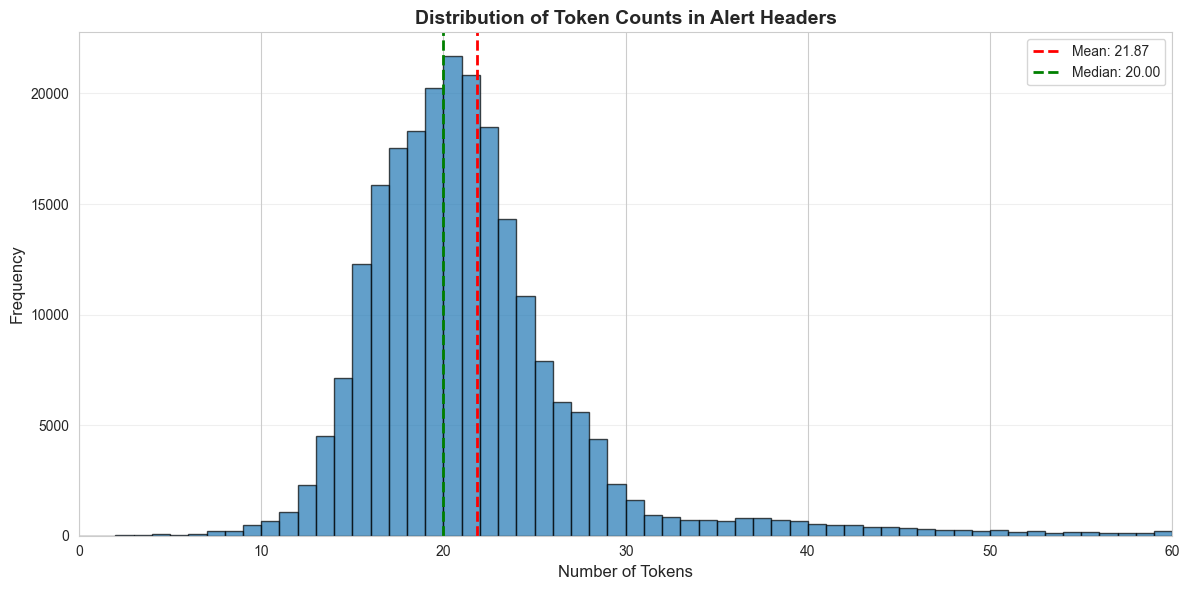

Saved to EDA/token_length_histogram.png


In [12]:
# Token length histogram
plt.figure(figsize=(12, 6))
plt.hist(df['token_count'], bins=60, range=(0, 60), edgecolor='black', alpha=0.7)
plt.xlabel('Number of Tokens', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Token Counts in Alert Headers', fontsize=14, fontweight='bold')
plt.axvline(df['token_count'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["token_count"].mean():.2f}')
plt.axvline(df['token_count'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df["token_count"].median():.2f}')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.xlim(0, 60)
plt.tight_layout()
plt.savefig(f'{output_dir}/token_length_histogram.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved to {output_dir}/token_length_histogram.png")


#### Summary

**CSV Files:**
- `missing_values.csv` - Missing value analysis
- `token_statistics.csv` - Token and character length statistics
- `word_statistics.csv` - Word count statistics
- `punctuation_frequency.csv` - Punctuation character frequencies
- `top_ngrams.csv` - Top 20 bigrams and trigrams
- `route_code_distribution.csv` - Single vs multiple route distribution
- `duplicate_headers.csv` - Status Label occurrences for duplicate headers
- `alerts_per_year.csv` - Temporal distribution of alerts

**Visualizations:**
- `token_length_histogram.png` - Distribution of token counts
